# Project single FF clusters on Gvec-based PC space derived from all FFs

In [1]:
from __future__ import absolute_import, division, print_function
import os
import glob
import numpy as np
import mdtraj as md
import barnaba as bb
from barnaba import definitions
import matplotlib as mpl
import matplotlib.pyplot as plt


indir = "../../REST2_dynamics/UUCG/300K"
outdir = "../output/UUCG/300K/Gvec_clusters-single_FF"

pdbdir = "%s/reference_structures/2KOC.pdb"%indir #directory of NMR models

os.system("mkdir %s" % outdir)
os.system("mkdir %s/snippets" %outdir)
os.system("mkdir %s/snippets_pdb" %outdir)

reference = "%s/reference_structures/UUCG-native.pdb"%indir  #usually is the native structure.
topol = "%s/reference_structures/UUCG-native.pdb"%indir  #doesn't have to be the same as reference.
traj1 = "%s/trajectories/traj-ff14SB-nmr.xtc"%indir  #needs to have the same number of atoms as the reference pdb.
traj2 = "%s/trajectories/traj-ff14SB-simrna.xtc"%indir  #needs to have the same number of atoms as the reference pdb.
sequence = "UUCG" #sequence of the hairpin loop (or the mobile part in general)

## Custom functions

In [2]:
#Function to create a custom cmap based on tab20 to be used throughout.
import matplotlib

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

In [3]:
#function to calculate eRMSD.
def ermsd_cluster(gvecs, centroids, labels):
    '''
    Calculate intra-cluster eRMSD. 
        gvecs: input features for eRMSD.
        centroids: array of cluster centroid G-vecs. 
        labels: array of cluster indexes. 
    '''
    ermsd = []
    #calculate the number of nucleotides from G-vecs shape
    N = (gvecs.shape[-1]/4)**0.5
    #calculate ermsd (based on Euclidean distance between Gvecs) for members of each cluster.
    for i in range(len(centroids)):
        idx=np.where(labels==i)[0]
        ermsd_i = [(1/N * np.sum((centroids[i]-gvecs[x])**2)**0.5 )**0.5 for x in idx]
        ermsd.append(ermsd_i)
    
    ermsd = np.asarray(ermsd, dtype='object')
    return ermsd


#Function to calculate cluster centroids.
def dbscan_centers(gvecs, labels, unique_labels):
    '''
    Find centroids of DBSCAN clusters.
    --gvecs: array of G-vectors (shape num_frames,4*num_nts*num_nts)
    --labels: DBSCAN-derived cluster label ids.
    --unique_labels: set of unique labels (contains noise).
    '''
    cent_idxs=[] #list to store the centroid indexes.
    
    N=(gvecs.shape[-1]/4)**0.5 #find num_nts.
    
    for i in range(len(unique_labels)-1): #exclude noise label which is at the end of the set.
        print("Finding centroid for cluster...%d"%i)
        idx = np.where(labels==i)[0]
        gvecs_temp = gvecs[idx]
        dists = squareform(pdist(gvecs_temp))/(float(N)**0.5) #calculate (all-to-all) eRMSD matrix.
        dd = np.sum(dists,axis=1) #sum eRMSDs for each cluster member.
        min_idx = np.argmin(dd) #centroid is the member that has minimum sum of eRMSDs.
        cent_idxs.append(idx[min_idx]) #get the cluster centroid index.
        
    return cent_idxs

# Generate snippets and calculate G-vectors

In [4]:
t = md.load([traj1, traj2], top=topol)
t.save("%s/../traj-ff14SB.pdb"%outdir) #we need a PDB-type input for this calculation. Saving whole trj can take a lot of time, so saving frames every 200 ps.
t.save("%s/../traj-ff14SB.xtc"%outdir) #we need a PDB-type input for this calculation. Saving whole trj can take a lot of time, so saving frames every 200 ps.

# Extract fragments from PDB files with a given sequence (doesn't support xtc trajectories).
bb.snippet("%s/../traj-ff14SB.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

# Include the native and seed states in trj snippet G-vecs. ("z_" prefix puts it at the end of the list)
native = md.load("%s/reference_structures/UUCG-native.pdb"%indir)
native.save("%s/z_UUCG-native.pdb"%outdir)
bb.snippet("%s/z_UUCG-native.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

seed1 = md.load("%s/reference_structures/UUCG-nmr.pdb"%indir)
seed1.save("%s/z_UUCG-nmr.pdb"%outdir)
bb.snippet("%s/z_UUCG-nmr.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

seed2 = md.load("%s/reference_structures/UUCG-simrna.pdb"%indir)
seed2.save("%s/z_UUCG-simrna.pdb"%outdir)
bb.snippet("%s/z_UUCG-simrna.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

NUM_REFS=3  #number of reference structures

# list the files and print the sequence. Could take a lot of time, and can be skipped.
flist = glob.glob("%s/snippets/*.pdb"%outdir)
file = open("%s/snippet_seqs.dat" %outdir, 'w')  
file.write("Total number of fragments with sequence %10s: %6d\n\n" %(sequence, len(flist)))
for f in flist:
    seq = [line[17:20].strip() for line in open(f) if line[12:16].strip()=="C2"]
    file.write("%-40s\t%4s\n" % (f, "".join(seq)))
file.close()

print("Total number of fragments with sequence %10s: %6d\n\n" %(sequence, len(flist)))

# Initializing file ../output/UUCG/300K/Gvec_clusters-single_FF/../traj-ff14SB.pdb


# Writing PDB traj-ff14SB_6_U_A_0_00000.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00001.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00002.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00003.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00004.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00005.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00006.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00007.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00008.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00009.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00010.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00011.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00012.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00013.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00014.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00015.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00016.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00017.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00018.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00019.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00020.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00021.pdb
# Writing PDB traj-ff14SB_6_U_A_

# Writing PDB traj-ff14SB_6_U_A_0_00197.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00198.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00199.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00200.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00201.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00202.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00203.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00204.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00205.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00206.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00207.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00208.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00209.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00210.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00211.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00212.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00213.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00214.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00215.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00216.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00217.pdb
# Writing PDB traj-ff14SB_6_U_A_0_00218.pdb
# Writing PDB traj-ff14SB_6_U_A_

limit_output extension: Maximum message size of 10000 exceeded with 10291 characters

In [5]:
# Cluster the structure obtained from the previous steps.

#calculate eRMSD from native.
ermsd = bb.ermsd(reference, "%s/../traj-ff14SB.xtc"%outdir, topology=topol)
ermsd_native = bb.ermsd(reference, "%s/z_UUCG-native.pdb"%outdir, topology=topol)
ermsd_seed1 = bb.ermsd(reference, "%s/z_UUCG-nmr.pdb"%outdir, topology=topol)
ermsd_seed2 = bb.ermsd(reference, "%s/z_UUCG-simrna.pdb"%outdir, topology=topol)
print(ermsd, ermsd_native, ermsd_seed1, ermsd_seed2)

#calculate RMSD from native using backbone heavy atoms of all nucleotides.
rmsd = bb.rmsd(reference, "%s/../traj-ff14SB.xtc"%outdir, topology=topol, heavy_atom=False)

#calculate the G-vectors
flist = glob.glob("%s/snippets/*.pdb"%outdir)
if(len(flist)==0):
    print("# You need to create a .pdb trajectory using e.g. gmx trjconv...")
    exit()
else:    
    print("Total number of fragments with sequence %s:"%sequence, len(flist))

    
# calculate G-vectors for all files (based on position vectors R).
# Gαβ vector cutoff is 2.4 Ang.
up_thresh=2.0 #only structures with eRMSD <= up_thresh will be considered. 
qq = np.where(ermsd<up_thresh)[0]
print("eRMSD < %1.2f array shape: "%up_thresh, qq.shape)
print("len. of eRMSDs < %1.2f "%up_thresh, len(ermsd[qq]))


try:
    gvecs = np.loadtxt("%s/snippets/Gvecs.txt"%outdir)
    print("G-vec file exists!")
    if len(gvecs)==len(ermsd[qq])+NUM_REFS:   #ACCOUNT FOR THE ADDITION OF NATIVE STATE AND SEED STATES
        print("G-vecs loaded!")
        print(gvecs.shape)
        n = gvecs.shape[0]
        print("G-vecs length: ", n)

    else:
        print("Native/seed states not in G-vec set. G-vecs need recalculation!")
except: 
    print("(Re)calcualating G-vecs!")
    #(Re)calculate G-vecs if needed.
    gvecs = []
    for f in flist:
        gvec,seq = bb.dump_gvec(f)
        assert len(seq)==4  #check that seq has correct length in order to proceed.
        gvecs.extend(gvec)
    # REMOVE SAMPLES WITH eRMSD > up_thresh and reshape array from (N, n, n, 4) to (N, n*n*4).    
    # the flattened array is given as input to the clustering routine.
    gvecs = np.array(gvecs)
    print(gvecs.shape)
    n = gvecs.shape[0]
    print(n)
    gvecs = gvecs.reshape(n,-1)[list(qq)+[len(ermsd)+i for i in range(NUM_REFS)]] #adding the reference structure indices 
    print(gvecs.shape)

    #Save the G-vectors so that you don't have to calculate them again :)
    np.savetxt("%s/snippets/Gvecs.txt"%outdir, gvecs, header="G-vectors of sequence %s, %d frames"%(sequence, len(flist)))

# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/../traj-ff14SB.xtc 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-native.pdb 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-nmr.pdb 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-simrna.pdb 


[0.42329955 0.52868025 0.46431981 ... 1.04384965 1.13302695 1.05507996] [0.] [0.28403547] [0.96303801]
# found  165 atoms in common
Total number of fragments with sequence UUCG: 100005
eRMSD < 2.00 array shape:  (100002,)
len. of eRMSDs < 2.00  100002
(Re)calcualating G-vecs!


# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00000.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00001.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00002.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00003.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00004.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00005.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00006.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00007.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00008.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00009.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippe

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00094.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00095.pdb 
# Loading ../output/UUCG/300K/Gvec_cluste

limit_output extension: Maximum message size of 10000 exceeded with 10993 characters

# Draw single FF clusters on combined FF Gvec space

## DBSCAN

In [6]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist


alltraj_dir="%s/../Gvec_clusters"%outdir #directory with Gvecs of combined FF trj
nmr = "%s/reference_structures/2KOC.pdb"%indir #experimental NMR models

traj = "%s/../traj-ff14SB.xtc" % outdir  #needs to have the same number of atoms as the reference pdb.
alltraj = "%s/../traj_all_ffs-rna-center.xtc" % alltraj_dir  #needs to have the same number of atoms as the reference pdb.

sequence = "UUCG"
gvecs="%s/snippets/Gvecs.txt"%outdir
gvecs=np.loadtxt(gvecs)
alltraj_gvecs="%s/snippets/Gvecs.txt"%alltraj_dir
alltraj_gvecs=np.loadtxt(alltraj_gvecs)

print(gvecs.shape)
print(alltraj_gvecs.shape)

(100005, 64)
(80011, 64)


In [7]:
# Calculate G-vecs of NMR ensemble models.

flist_nmr = glob.glob("%s/snippets_pdb/*.pdb"%alltraj_dir)

gvecs_nmr = []
for f in flist_nmr:
    gvec_nmr, seq_nmr = bb.dump_gvec(f)
    gvecs_nmr.extend(gvec_nmr)
    
gvecs_nmr = np.array(gvecs_nmr)
n_nmr = gvecs_nmr.shape[0]
# gvecs_nmr = gvecs_nmr.reshape(n_pdb,-1)[np.where(ermsd_pdb<up_thresh)]
gvecs_nmr = gvecs_nmr.reshape(n_nmr,-1) #NOT IMPOSING ANY THRESHOLD

print(gvecs_nmr.shape)

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00000.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00001.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00002.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00003.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00004.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00005.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00006.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00007.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00008.pdb 
# Loading ../output/UUCG/300

(20, 64)


# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00018.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00019.pdb 


In [8]:
#Do PCA with 3 features (to be comparable with previous PCA/DBSCAN decomposition of G-vecs).
#Will embed the Gvecs of this ff to a space common to all ffs.
dims=3
pca = PCA(n_components=dims)
pca.fit(alltraj_gvecs) #creating a PC space from all trajectories.
np.savetxt("%s/PCA_%dcomp_components-alltraj.txt"%(outdir, dims), pca.components_, header="# Loadings of the %d PCA components of alltraj."%dims)
X = pca.transform(gvecs) #these are the ff-specific data transformed in alltraj PC space.
NMR = pca.transform(gvecs_nmr)

print(pca.explained_variance_)
print(["%2.2f"%(i*100)+"%" for i in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.73713782 0.56135227 0.33260168]
['21.18%', '16.13%', '9.56%']
0.468659343393111


In [9]:
#try DBSCAN with usual eps value.
eps=0.5
min_samples=200

gvecs_dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=2)
gvecs_dbscan.fit(gvecs)

labels = gvecs_dbscan.labels_# label=-1 means the point is an outlier. Rest of the values represent the label/cluster number starting from 0
print(labels)

# Creating a numpy array with all values set to false by default
core_samples_mask = np.zeros_like(labels, dtype=bool)
# Setting core and border points (all points that are not -1) to True
core_samples_mask[gvecs_dbscan.core_sample_indices_] = True

# Finding the number of clusters in labels (ignoring noise if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d"%n_noise_, "(%.1f%s)"%(100*n_noise_/gvecs.shape[0],"%"))

# Evaluating the quality of clusters
s = metrics.silhouette_score(gvecs, gvecs_dbscan.labels_)
print(f"Silhouette Coefficient for the Dataset Clusters: {s:.2f}")

[ 0 -1  0 ...  0  0 -1]
Estimated number of clusters: 24
Estimated number of noise points: 34664 (34.7%)
Silhouette Coefficient for the Dataset Clusters: 0.21


In [10]:
#find cluster centroids (i.e. members with lowest sum of intra-cluster eRMSDs).
unique_labels = set(labels)

cent_idxs = dbscan_centers(gvecs, labels, unique_labels)
print(cent_idxs)

#find cluster populations relative to total data.
print("Noise population: %.1f"%(100*np.sum(labels==(-1))/labels.shape[0])+"%")
pops = [(np.sum(labels==i)/labels.shape[0] *100) for i in range(len(unique_labels)-1)]
print(pops)

sorted_pops = np.sort(pops)[::-1] #create a reverse-sorted copy

#create a dictionary that relates sorted cluster indexes (keys: 0 is largest cluster) to DBSCAN cluster labels (values).
sort_clust_map={}
for i in range(len(cent_idxs)):
    dupl_count=np.sum(int(np.where(pops==sorted_pops[i])[0][0]) in list(sort_clust_map.values())) #counter to handle possible duplicates.
    sort_clust_map[i]=int(np.where(pops==sorted_pops[i])[0][dupl_count])
print(sort_clust_map)

Finding centroid for cluster...0
Finding centroid for cluster...1
Finding centroid for cluster...2
Finding centroid for cluster...3
Finding centroid for cluster...4
Finding centroid for cluster...5
Finding centroid for cluster...6
Finding centroid for cluster...7
Finding centroid for cluster...8
Finding centroid for cluster...9
Finding centroid for cluster...10
Finding centroid for cluster...11
Finding centroid for cluster...12
Finding centroid for cluster...13
Finding centroid for cluster...14
Finding centroid for cluster...15
Finding centroid for cluster...16
Finding centroid for cluster...17
Finding centroid for cluster...18
Finding centroid for cluster...19
Finding centroid for cluster...20
Finding centroid for cluster...21
Finding centroid for cluster...22
Finding centroid for cluster...23
[250, 97594, 28809, 53270, 34719, 86014, 2305, 90613, 75784, 68525, 64876, 94164, 8786, 8681, 68309, 14168, 53186, 71684, 49775, 40374, 73160, 74389, 79005, 79828]
Noise population: 34.7%
[1.780

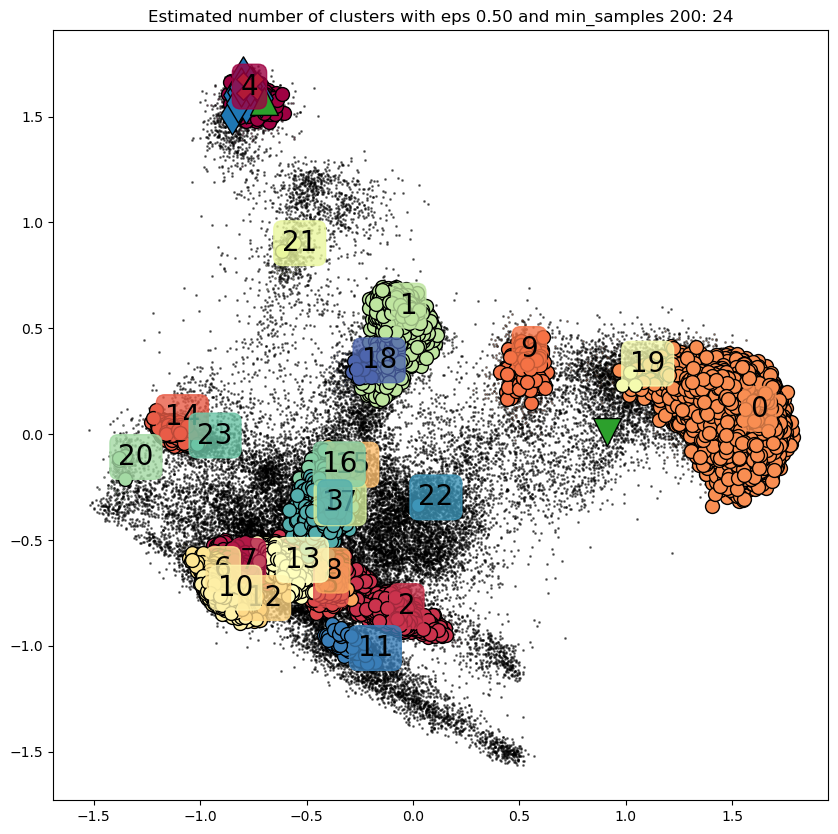

In [11]:
#Plot the results.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10,10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = "k"
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]  #Plot the points on the PC space.
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col, markeredgecolor="k", markersize=10)    

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col, markeredgecolor="k", markersize=1, zorder=1, alpha=0.5)

#Plot native/seed states. We know their indexes from notebook #4
plt.scatter(X[-3,0], X[-3,1], s=400, lw=1, c="tab:orange", ec='black', zorder=2*len(unique_labels)+1, marker="X")
plt.scatter(X[-2,0], X[-2,1], s=400, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="^")
plt.scatter(X[-1,0], X[-1,1], s=400, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="v")
plt.scatter(NMR[:,0], NMR[:,1], s=400, lw=1, c="tab:blue", ec="black", zorder=2*len(unique_labels), marker="d")

#Add centroid labels.
for i in range(len(unique_labels)-1):
    plt.annotate(list(sort_clust_map.keys())[list(sort_clust_map.values()).index(i)], (X[cent_idxs[i],0], X[cent_idxs[i],1]), c='k', zorder=3*len(unique_labels), \
                 fontsize=20, bbox=dict(boxstyle="round", alpha=0.8, color=colors[i]))

plt.title("Estimated number of clusters with eps %.2f and min_samples %d: %d" %(eps, min_samples, n_clusters_))
plt.show()

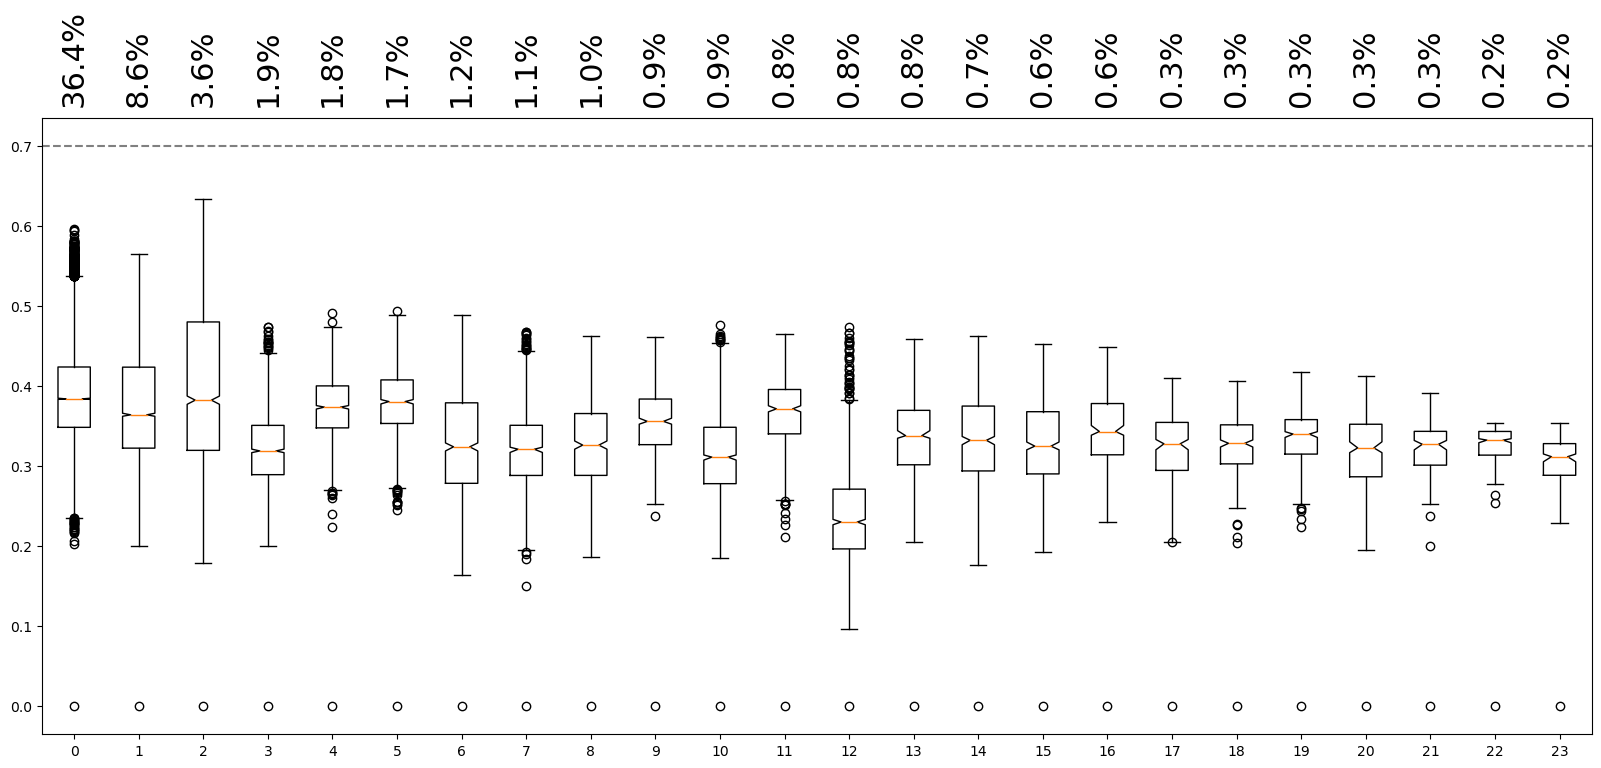

In [12]:
#calculate intra-cluster loop eRMSDs.
ermsds = ermsd_cluster(gvecs, gvecs[cent_idxs], labels)

ermsds_sorted = [ermsds[i] for i in list(sort_clust_map.values())]

#plot intra-cluster eRMSDs along with cluster populations. 
#Distributions might differ from Barnaba because it calculates intra-cluster eRMSDs using whole structures!
plt.figure(figsize=(20, 8))
plt.boxplot(ermsds_sorted, notch=True, bootstrap=1000, labels=range(len(cent_idxs)))
for j in range(len(sorted_pops)):
    plt.text((j+1), 0.75, "%.1f%s"%(sorted_pops[j],"%"), ha='center', va='bottom', rotation=90, fontsize=22)
plt.axhline(0.7, ls='--', c='grey')

plt.show()

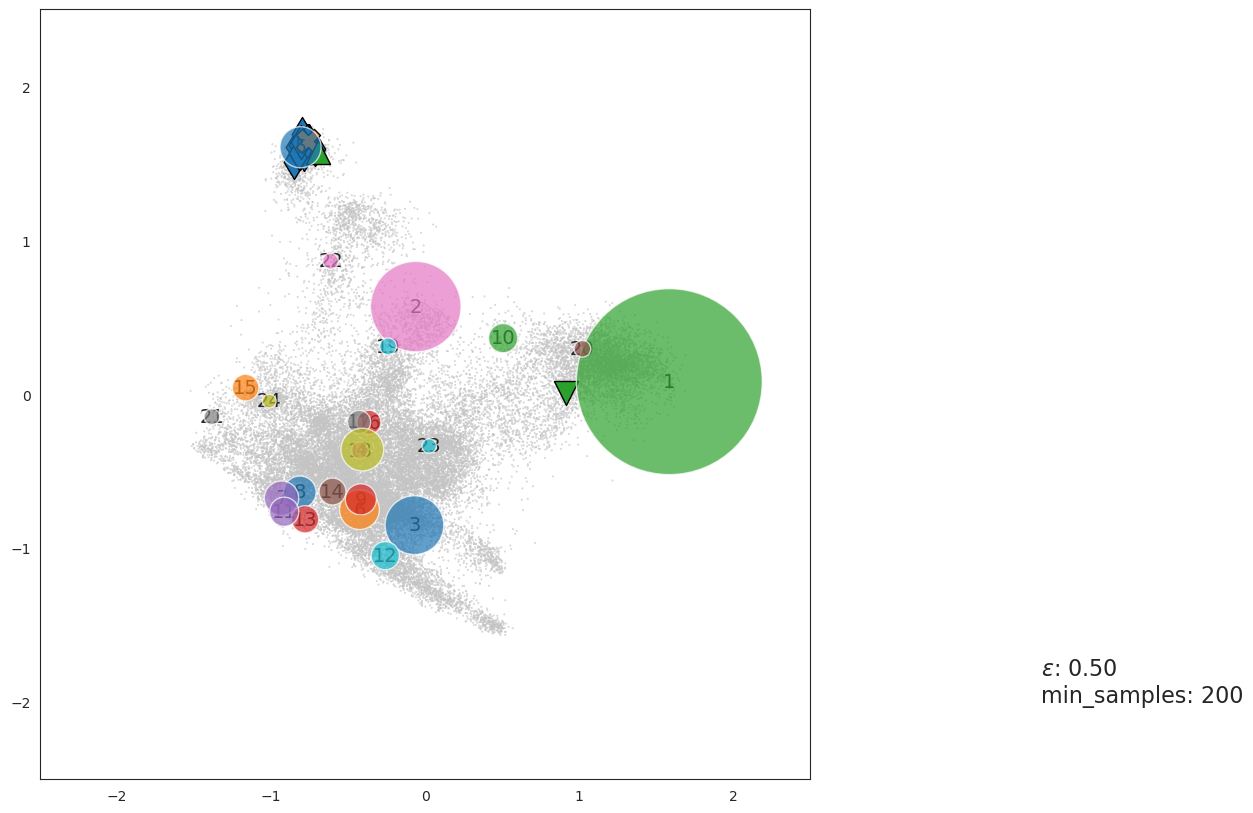

In [13]:
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

#define figure and set aspect.
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

# #calculate explained variance for the first two components.
# plt.xlabel(r'PC1 (%2.0f%s)' %(v[0]*100,"%"), fontsize=12)
# plt.ylabel(r'PC2 (%2.0f%s)' %((v[1]-v[0])*100,"%"), fontsize=12)
# print("# Cumulative explained variance percentage: PC1=%5.1f PC2=%5.1f PC3=%5.1f" %(v[0]*100,v[1]*100,v[2]*100))

#define colors for clusters. Noise is grey points.
cp = sns.color_palette("hls", n_colors=len(cent_idxs), desat=0.8)
colors = [cp[j-1] if (j!=-1) else (0.77,0.77,0.77) for j in labels]
size = [0.12 if (j==-1) else 0.0 for j in labels]

#scatterplot all points.
plt.scatter(X[:,0],X[:,1], s=size, c=colors, zorder=0)
plt.scatter(X[-3,0], X[-3,1], s=300, lw=1, c="tab:orange", ec="black", zorder=2*len(unique_labels)+1, marker="X")
plt.scatter(X[-2,0], X[-2,1], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="^")
plt.scatter(X[-1,0], X[-1,1], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="v")
plt.scatter(NMR[:,0], NMR[:,1], s=300, lw=1, c="tab:blue", ec="black", zorder=2*len(unique_labels), marker="d")

#make circles in the center of the cluster
patches = []
new_labels = np.array(labels)
for i,k in enumerate(cent_idxs):
    plt.text(X[cent_idxs[i],0], X[cent_idxs[i],1], \
             list(sort_clust_map.keys())[list(sort_clust_map.values()).index(i)]+1, \
             ha="center", va="center", fontsize=14, zorder=3*len(unique_labels))
    #make the circle radius proportional to the square root of the cluster size.
    rr = np.sqrt(1.*len(np.where(new_labels==i)[0])/len(new_labels))
    circle = mpatches.Circle((X[k,0], X[k,1]), rr, ec='black', lw=4)
    patches.append(circle)
p = PatchCollection(patches, cmap=mpl.cm.tab10, alpha=0.7, zorder=3*len(unique_labels))
p.set_array(np.arange(len(cent_idxs))+1)
ax.add_collection(p)

#set nice limits
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-2,-1,0,1,2])
props = dict(boxstyle='round', facecolor='white', alpha=0.3)
plt.text(4, -2, s=r'$\epsilon$: %.2f'%eps+"\n"+"min_samples: %d"%min_samples, bbox=props, fontsize=16)
# plt.title("G-vector PCA - eRMSD threshold %s" %up_thresh, fontsize=16)
plt.savefig("%s/Gvec_clusters-w_radius-PC1_PC2-eps%s_min%s.png" %(outdir, eps, min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

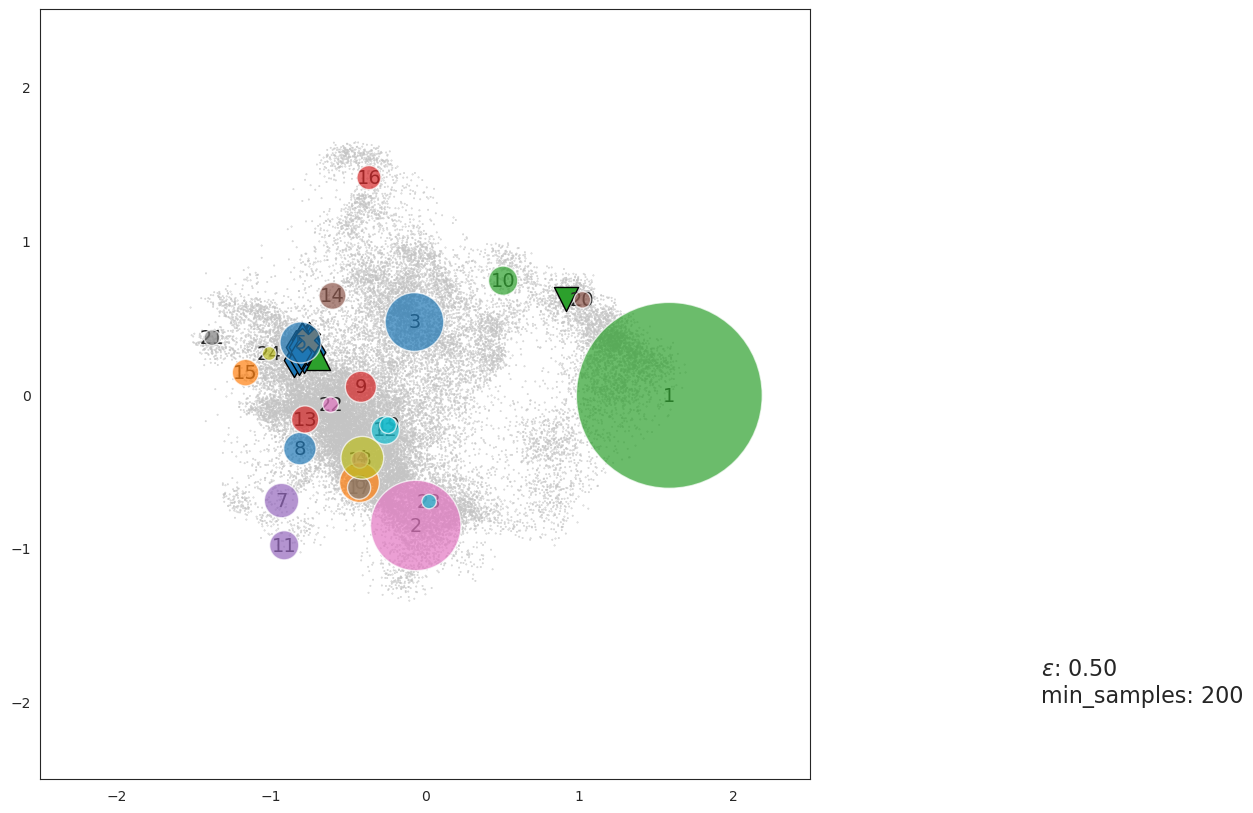

In [14]:
# Do the same for PC 1-3

#define figure and set aspect.
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

#scatterplot all points.
plt.scatter(X[:,0],X[:,2], s=size, c=colors, zorder=0)
plt.scatter(X[-3,0], X[-3,2], s=300, lw=1, c="tab:orange", ec="black", zorder=2*len(unique_labels)+1, marker="X")
plt.scatter(X[-2,0], X[-2,2], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="^")
plt.scatter(X[-1,0], X[-1,2], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="v")
plt.scatter(NMR[:,0], NMR[:,2], s=300, lw=1, c="tab:blue", ec="black", zorder=2*len(unique_labels), marker="d")

#make circles in the center of the cluster
patches = []
new_labels = np.array(labels)
for i,k in enumerate(cent_idxs):
    plt.text(X[cent_idxs[i],0], X[cent_idxs[i],2], \
             list(sort_clust_map.keys())[list(sort_clust_map.values()).index(i)]+1, \
             ha="center", va="center", fontsize=14, zorder=3*len(unique_labels))
    #make the circle radius proportional to the square root of the cluster size.
    rr = np.sqrt(1.*len(np.where(new_labels==i)[0])/len(new_labels))
    circle = mpatches.Circle((X[k,0], X[k,2]), rr, ec='black', lw=4)
    patches.append(circle)
p = PatchCollection(patches, cmap=mpl.cm.tab10, alpha=0.7, zorder=3*len(unique_labels))
p.set_array(np.arange(len(cent_idxs))+1)
ax.add_collection(p)

#set nice limits
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-2,-1,0,1,2])
props = dict(boxstyle='round', facecolor='white', alpha=0.3)
plt.text(4, -2, s=r'$\epsilon$: %.2f'%eps+"\n"+"min_samples: %d"%min_samples, bbox=props, fontsize=16)
# plt.title("G-vector PCA - eRMSD threshold %s" %up_thresh, fontsize=16)
plt.savefig("%s/Gvec_clusters-w_radius-PC1_PC3-eps%s_min%s.png" %(outdir, eps, min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Cluster populations

In [15]:
# Save the cluster centroids to PDB files and cluster members to xtc trajectories for further analysis.

clustdir = "%s/snippet_clusters-eps%s_min%s" %(outdir, eps, min_samples)
os.system("mkdir %s" % clustdir)

print("# Write centroids to PDB files and cluster members to .xtc")
print(t)

# Write centroids to PDB files and cluster members to .xtc
<mdtraj.Trajectory with 100002 frames, 447 atoms, 14 residues, and unitcells>


In [16]:
dd1 = []  #will store the eRMSDs of each frame to its centroid.
dd2 = []  #will store the RMSDs of each frame to its centroid.
ll = []  #will store the cluster population relative to all the frames. 

for i,k in enumerate([cent_idxs[j] for j in sort_clust_map.values()]):
    t[qq[k]].save_gro("%s/cluster_%03d.gro" %(clustdir, i))
#     idxs = [ii for ii,kk in enumerate(new_labels[:-NUM_REFS]) if(kk==i+1)] #exclude native/seed states
    idxs = [ii for ii,kk in enumerate(new_labels[:-NUM_REFS]) if(kk==sort_clust_map[i])] #exclude native/seed states
#     idxs = np.where(new_labels[:-NUM_REFS]==sort_clust_map[i])[0] #exclude native/seed states 
    print(len(idxs))
    t[qq[idxs]].save_xtc("%s/cluster_%03d.traj.xtc" %(clustdir, i))
    ll.append(100.*len(idxs)/(n))
    ermsd_t = bb.ermsd("%s/cluster_%03d.gro" %(clustdir,i), "%s/cluster_%03d.traj.xtc" %(clustdir, i), topology=topol)
    rmsd_t = bb.rmsd("%s/cluster_%03d.gro" %(clustdir,i), "%s/cluster_%03d.traj.xtc" %(clustdir,i), topology=topol, heavy_atom=False)
    dd1.append(ermsd_t)
    dd2.append(rmsd_t)

36431


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_000.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_000.traj.xtc 


# found  165 atoms in common
8612


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_001.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_001.traj.xtc 


# found  165 atoms in common
3633


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_002.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_002.traj.xtc 


# found  165 atoms in common
1926


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_003.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_003.traj.xtc 


# found  165 atoms in common
1779


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_004.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_004.traj.xtc 


# found  165 atoms in common
1669


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_005.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_005.traj.xtc 


# found  165 atoms in common
1245


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_006.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_006.traj.xtc 


# found  165 atoms in common
1106


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_007.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_007.traj.xtc 


# found  165 atoms in common
1020


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_008.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_008.traj.xtc 


# found  165 atoms in common
897


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_009.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_009.traj.xtc 


# found  165 atoms in common
896


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_010.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_010.traj.xtc 


# found  165 atoms in common
837


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_011.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_011.traj.xtc 


# found  165 atoms in common
782


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_012.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_012.traj.xtc 


# found  165 atoms in common
762


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_013.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_013.traj.xtc 


# found  165 atoms in common
744


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_014.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_014.traj.xtc 


# found  165 atoms in common
606


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_015.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_015.traj.xtc 


# found  165 atoms in common
566


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_016.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_016.traj.xtc 


# found  165 atoms in common
303


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_017.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_017.traj.xtc 


# found  165 atoms in common
294


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_018.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_018.traj.xtc 


# found  165 atoms in common
291


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_019.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_019.traj.xtc 


# found  165 atoms in common
262


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_020.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_020.traj.xtc 


# found  165 atoms in common
259


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_021.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_021.traj.xtc 


# found  165 atoms in common
219


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_022.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_022.traj.xtc 


# found  165 atoms in common
200


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_023.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_023.traj.xtc 


# found  165 atoms in common


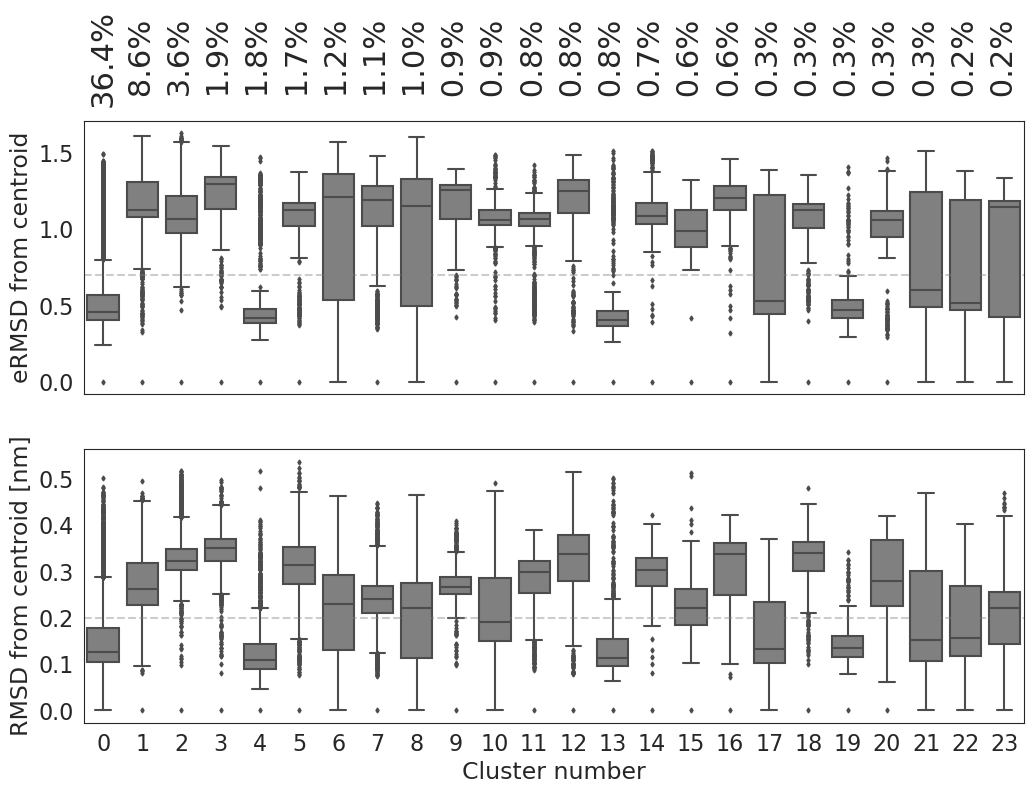

In [17]:
# Box-plot the clustered data to get population statistics (e.g. we can see cluster compactness).

#define the figure.
f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(11,7))
#do the boxplot
ax1 = sns.boxplot(data=dd1, color='0.5', ax=ax1, fliersize=2.5)
ax1.axhline(0.7, color='grey', alpha=0.4, ls='--')

ax2 = sns.boxplot(data=dd2, color='0.5', fliersize=2.5)
ax2.axhline(0.2, color='grey', alpha=0.4, ls='--')

#write percentages.
for j in range(len(ll)):
    ax1.text(j, 1.8, "%4.1f%s" %(ll[j],"%"), ha='center', va='bottom', rotation=90, fontsize=22)
#set limits and labels
ax1.set_ylabel("eRMSD from centroid", fontsize=17)
ax1.tick_params(axis='both', labelsize=16)

# ax2.set_ylim(0, 0.5)
ax2.set_ylabel("RMSD from centroid [nm]", fontsize=17)
ax2.set_xlabel("Cluster number", fontsize=17)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticklabels([str(i) for i in range(len(ll))])
plt.subplots_adjust(right=0.98, top=0.97)
plt.savefig("%s/eRMSD_cluster_boxplts-eps%s_min%s.png" %(outdir, eps*np.sqrt(len(sequence)), min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [18]:
# [print(flist[list(sort_clust_map.values())[i]]) for i in range(len(cent_idxs))]
[print(flist[cent_idxs[sort_clust_map[i]]]) for i in range(len(cent_idxs))]

print(sort_clust_map.values())

# Write a file containing the cluster centroids.
with open("%s/cluster_centroids.txt" %clustdir, 'w') as file:
    for n, idx in enumerate([cent_idxs[sort_clust_map[i]] for i in range(len(cent_idxs))]):
        file.write("cluster %d: ../%s"%(n, flist[idx][len(outdir)+1:]) ) #avoid the path and suffix form name
        file.write("\n")

../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_02305.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_53184.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_28807.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_73158.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_00250.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_53268.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_64874.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_97592.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_90611.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_86012.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_94162.pdb
../output/UUCG/300K/Gvec_clusters-single_FF/snippets/traj-ff14SB_6_U_A_0_79003.pdb
../o

# found  165 atoms in common
# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_000.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_001.gro 


# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_002.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_003.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_004.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_005.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_006.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_007.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_008.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_009.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_010.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_011.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_012.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_013.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_014.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_015.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_016.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_017.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_018.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_019.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_020.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_021.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_022.gro 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_023.gro 


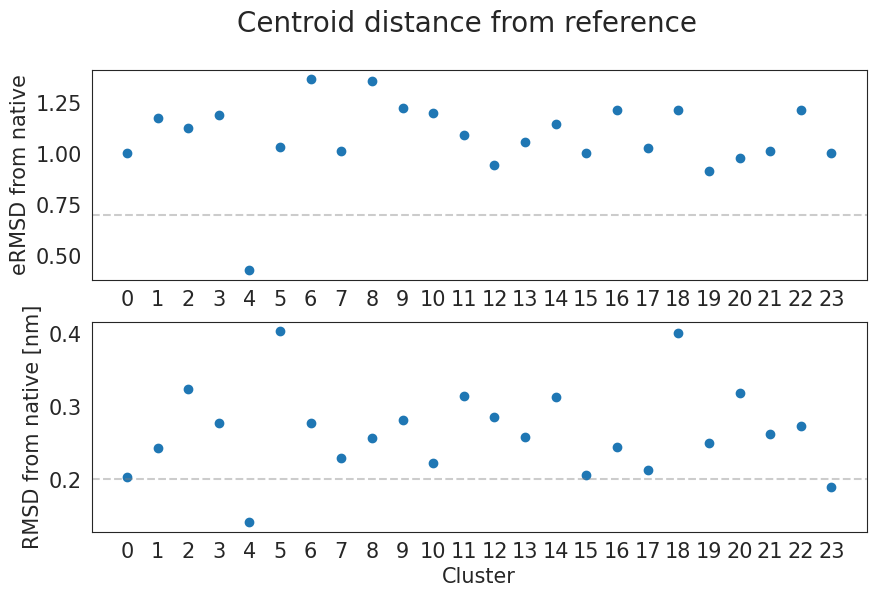

In [19]:
# Calculate the RMSD and eRMSD of centroids to reference structure.

rmsds = []
ermsds = []

with open("%s/centroids_e-RMSD_to_ref.dat" %clustdir, 'w') as file:
    file.write("Cluster_id\tRMSD\teRMSD\n")
    for i in range(len(cent_idxs)):
        #calculate RMSD on backbone heavy atoms (heavy_atom=False)
        rmsd = bb.rmsd(reference, "%s/cluster_%03d.gro" %(clustdir, i) , out="%s/cluster_%03d.aligned.pdb" %(clustdir, i), heavy_atom=False)
        rmsd = bb.rmsd(reference, "%s/cluster_%03d.gro" %(clustdir, i) , out="%s/cluster_%03d.aligned.gro" %(clustdir, i), heavy_atom=False)
        rmsds.append(rmsd)
        ermsd = bb.ermsd(reference, "%s/cluster_%03d.gro" %(clustdir, i))
        ermsds.append(ermsd)
        file.write("%d\t%f\t%f\n" %(i, rmsd, ermsd))

plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2,1), (0,0))
ax1.scatter(range(len(ermsds)), ermsds)
ax1.axhline(0.7, color='grey', alpha=0.4, ls='--')
ax1.set_ylabel("eRMSD from native", fontsize=15)
ax1.set_xticks(range(len(ermsds)))
ax1.tick_params(axis='both', labelsize=15)

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.scatter(range(len(rmsds)), rmsds)
ax2.axhline(0.2, color='grey', alpha=0.4, ls='--')
ax2.set_ylabel("RMSD from native [nm]", fontsize=15)
ax2.set_xticks(range(len(rmsds)))
ax2.tick_params(axis='both', labelsize=15)
ax2.set_xlabel("Cluster", fontsize=15)

plt.suptitle("Centroid distance from reference", size=20)

plt.savefig("%s/e-RMSD_from_native-eps%s_min%s.png" %(outdir, eps, min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Dynamic Secondary Structures

In [20]:
# Produce the dynamic secondary structures of the clusters.

dynadir = "%s/cluster_dss-eps%s_min%s" %(outdir, eps, min_samples)
os.system("mkdir %s" % dynadir)

#first produce the DSS of the reference (native) structure.
cmd1 = "barnaba ANNOTATE --trj %s --top %s -o %s/reference" %(reference, reference, dynadir)
cmd2 = "barnaba SEC_STRUCTURE --ann %s/reference.ANNOTATE.stacking.out %s/reference.ANNOTATE.pairing.out -o %s/reference" %(dynadir, dynadir, dynadir)

os.system(cmd1)
os.system(cmd2)

# Loading ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/reference.ANNOTATE
# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/reference.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/reference.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/reference.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hres(max_F)
Added ordering pot [ 2. 11.  3. 10.]
       0 5.997e+06  6.39e+04  1.00e+00         5
      50 2.277e+06  1.70e+04  2.48e-01        11
Added ordering pot [ 3. 10.  4.  9.]
      81 2.247e+06  3.07e+03  1.00e+00         2
Added ordering pot [4. 9. 5. 8.]
      86 2.401e+06  2.31e+03  1.00e+00   

/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


0

In [21]:
#do the same for the produced clusters.
for i in range(len(ll)):
    cmd1 = "barnaba ANNOTATE --trj %s/cluster_%03d.traj.xtc --top %s -o %s/c%d" %(clustdir,i, topol, dynadir,i)
    cmd2 = "barnaba SEC_STRUCTURE --ann %s/c%d.ANNOTATE.stacking.out %s/c%d.ANNOTATE.pairing.out -o %s/c%d" %(dynadir,i, dynadir,i, dynadir,i)
    
    os.system(cmd1)
    os.system(cmd2)
    print(cmd1)
    

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_000.traj.xtc 


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c0.ANNOTATE


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c0.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c0.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c0.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hres(max_F)
Added ordering pot [ 2. 11.  3. 10.]
       0 5.411e+06  4.26e+04  1.00e+00         1
      50 2.239e+06  2.09e+04  1.53e-01         2
Added ordering pot [ 3. 10.  4.  9.]
      86 2.106e+06  4.70e+03  1.00e+00        11
Added ordering pot [4. 9. 5. 8.]
      92 2.308e+06  2.03e+03  1.00e+00         9
     100 2.178e+06  3.95e+03  1.43e-01        11
Added ordering pot [ 0. 13.  1. 12.]
     124 2.232e+06  3.13e+03  1.00e+00         4
Added ordering pot

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_001.traj.xtc 
/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c1.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c1.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c1.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hres(max_F)
Added ordering pot [ 2. 11.  3. 10.]
       0 5.534e+06  4.24e+04  1.00e+00         1
Added ordering pot [ 3. 10.  4.  9.]
      50 2.337e+06  1.37e+04  1.00e+00        11
     100 2.196e+06  6.86e+03  1.16e-01        10
Added ordering pot [4. 9. 5. 8.]
     101 2.473e+06  4.33e+03  1.00e+00         9
Added ordering pot [ 0. 13.  1. 12.]
     136 2.305e+06  4.78e+03  1.00e+00         4
     150 2.235e+06  2.48e+03  8.56e-02         4
Added ordering pot

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_002.traj.xtc 


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c2.ANNOTATE


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c2.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c2.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c2.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hres(max_F)
Added ordering pot [ 2. 11.  3. 10.]
       0 5.407e+06  4.64e+04  1.00e+00         9
      50 2.318e+06  1.40e+04  1.06e-01         2
Added ordering pot [ 3. 10.  4.  9.]
      88 2.197e+06  4.66e+03  1.00e+00         2
Added ordering pot [4. 9. 5. 8.]
      94 2.422e+06  3.77e+03  1.00e+00         4
     100 2.274e+06  1.42e+04  4.15e-01         9
Added ordering pot [ 0. 13.  1. 12.]
     136 2.319e+06  3.80e+03  1.00e+00         9
Added ordering pot

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_003.traj.xtc 


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c3.ANNOTATE


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c3.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c3.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c3.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hres(max_F)
Added ordering pot [ 2. 11.  3. 10.]
       0 4.258e+06  4.05e+04  1.00e+00         1
      50 2.066e+06  1.32e+04  2.13e-01        11
     100 1.974e+06  3.42e+03  1.24e-01        10
Added ordering pot [ 3. 10.  4.  9.]
     107 1.989e+06  2.19e+03  1.00e+00         2
Added ordering pot [ 0. 13.  1. 12.]
     112 2.148e+06  2.66e+03  1.00e+00         2
Added ordering pot [ 1. 12.  2. 11.]
     136 2.091e+06  1.77e+03  1.00e+00         9
     150 2.025

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200/cluster_004.traj.xtc 


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c4.ANNOTATE


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/barnaba/functions.py:1431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds_all = np.array(ds_all)[sortkeys][::-1]


# your output will be written to files with prefix ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c4.SEC_STRUCTURE
Using annotation file(s) for structure minimization.
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c4.ANNOTATE.stacking.out
Parsing file  ../output/UUCG/300K/Gvec_clusters-single_FF/cluster_dss-eps0.5_min200/c4.ANNOTATE.pairing.out
Calc parameters ...
... done
Start on circle
Make starting config
# E thresh: 5.00e-05
    Step    energy     F_max         hr

limit_output extension: Maximum message size of 10000 exceeded with 11020 characters

## Contour plots

In [22]:
t = md.load([traj1, traj2], top=topol)
print(t)

<mdtraj.Trajectory with 100002 frames, 447 atoms, 14 residues, and unitcells>


There are 50001 frames per trajectory.
# Cumulative explained variance percentage: PC1= 21.2 PC2= 16.1 PC3=  9.6
(50001,)
(50001,)
(50001,)
(50001,)


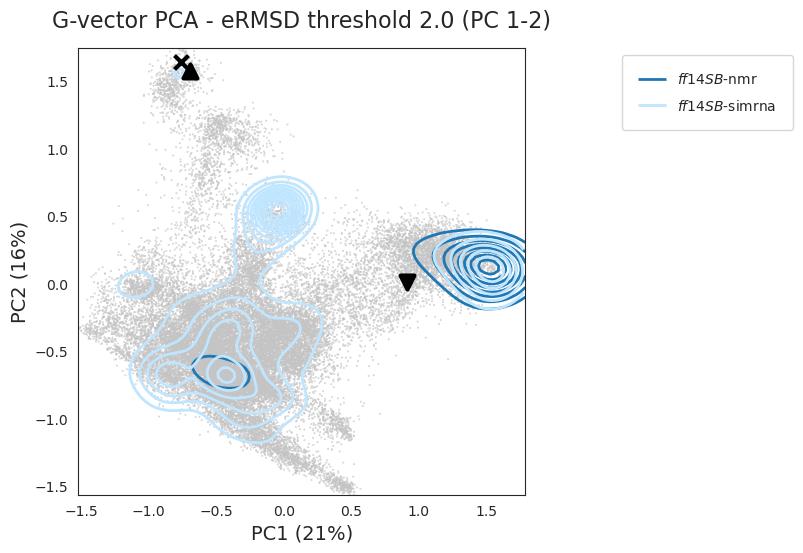

In [23]:
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.cm as cm
import seaborn as sns

def density_estimation(m1, m2):
    xmin = np.min(m1)
    xmax = np.max(m1)
    ymin = np.min(m2)
    ymax = np.max(m2)

    x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([x.ravel(), y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    z = np.reshape(kernel(positions).T, x.shape)
    return x, y, z , xmin, xmax, ymin, ymax

# define some basic stuff for data.
ffs = ["ff14SB"]
runs = ["nmr", "simrna"]
fr_per_trj=len(t)//(len(ffs)*len(runs))
print("There are %d frames per trajectory."%fr_per_trj)
dims = [0, 1]
size = [0.12 if (j==-1) else 0.0 for j in labels]


#define figure and set aspect.
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8.3,5.8))
ax.set_aspect(1)

#calculate explained variance for the first two components.
ax.set_xlabel(r'PC1 (%2.0f%s)' %(pca.explained_variance_ratio_[0]*100,"%"), fontsize=12)
ax.set_ylabel(r'PC2 (%2.0f%s)' %(pca.explained_variance_ratio_[1]*100,"%"), fontsize=12)
print("# Cumulative explained variance percentage: PC1=%5.1f PC2=%5.1f PC3=%5.1f" \
      %(pca.explained_variance_ratio_[0]*100,pca.explained_variance_ratio_[1]*100,pca.explained_variance_ratio_[2]*100))

#define colors for clusters. Noise is gray points.
cp = sns.color_palette("hls", n_colors=len(cent_idxs), desat=0.8)
clust_colors = [cp[j-1] if (j!=-1) else (0.77,0.77,0.77) for j in labels]
#define colors for contours.
cat_cmap = categorical_cmap(len(ffs), len(runs), "tab10")

#scatterplot the noise
ax.scatter(X[:,0],X[:,1], s=size, c=clust_colors, zorder=0)

#plot the contours.
counter=0
legend_handles=[]

for r in runs:

    x = X[counter*fr_per_trj:(counter+1)*fr_per_trj, 0]
    y = X[counter*fr_per_trj:(counter+1)*fr_per_trj, 1]

    print(x.shape)
    print(y.shape)
    
        
    x, y, z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(z).max(), vmin=-abs(z).max())

    CS = ax.contour(x, y, z, 10, colors=cat_cmap([counter]), extend=max, linewidths=2)
    CS.collections[counter].set_label("$%s$ (%s)"%(ffs[0], r))
        
    #save legend hadles
    h,_ = CS.legend_elements()
    legend_handles.append(h)
    
    counter+=1

#Plot near-native point (the first one since (if) trajectory starts from native state.)
plt.scatter(X[-NUM_REFS,0], X[-NUM_REFS,1], s=100, lw=3, c="black", zorder=3, marker="x", label="Native") #plot native
plt.scatter(X[-(NUM_REFS-1),0], X[-(NUM_REFS-1),1], s=100, lw=3, c="black", zorder=3, marker="^", label="NMR seed") #plot seed
plt.scatter(X[-(NUM_REFS-2),0], X[-(NUM_REFS-2),1], s=100, lw=3, c="black", zorder=3, marker="v", label="Simrna seed") #plot seed
# plt.scatter(NMR[:,0], NMR[:,1], s=50, lw=1, c="black", alpha=1, zorder=2, marker="+") #plot NMR ensemble

#set nice limits
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend([H[0] for H in legend_handles], ["$%s$-%s"%(ffs[0], r) for r in runs], loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2, ncol=1)
plt.title("G-vector PCA - eRMSD threshold %s (PC 1-2)" %up_thresh, fontsize=16, pad=15)
plt.savefig("%s/Gvec_contours-%s-pc_1-2.png" %(outdir, ffs[0]), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

# Cumulative explained variance percentage: PC1= 21.2 PC2= 16.1 PC3=  9.6


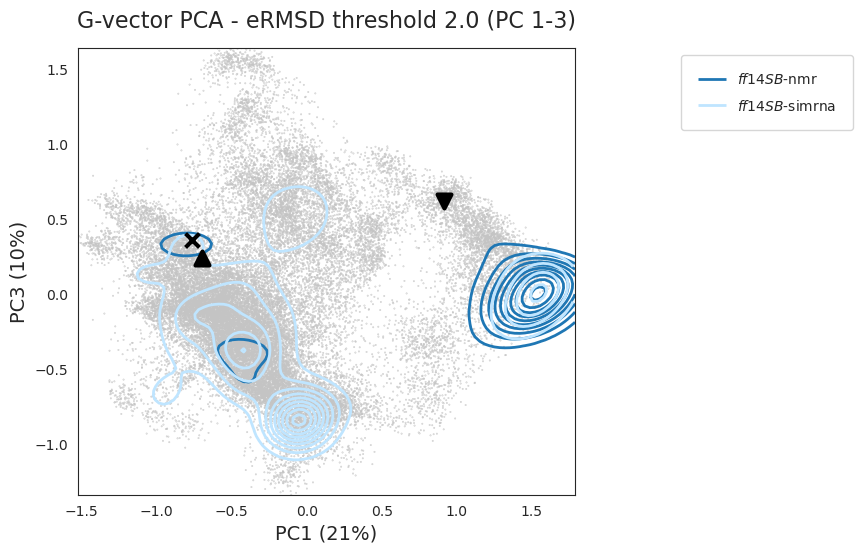

In [24]:
#define figure and set aspect.
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8.3,5.8))
ax.set_aspect(1)

#calculate explained variance for the first two components.
ax.set_xlabel(r'PC1 (%2.0f%s)' %(pca.explained_variance_ratio_[0]*100,"%"), fontsize=12)
ax.set_ylabel(r'PC3 (%2.0f%s)' %(pca.explained_variance_ratio_[2]*100,"%"), fontsize=12)
print("# Cumulative explained variance percentage: PC1=%5.1f PC2=%5.1f PC3=%5.1f" \
      %(pca.explained_variance_ratio_[0]*100,pca.explained_variance_ratio_[1]*100,pca.explained_variance_ratio_[2]*100))

#define colors for clusters. Noise is gray points.
cp = sns.color_palette("hls", n_colors=len(cent_idxs), desat=0.8)
clust_colors = [cp[j-1] if (j!=-1) else (0.77,0.77,0.77) for j in labels]
#define colors for contours.
cat_cmap = categorical_cmap(len(ffs), len(runs), "tab10")

#scatterplot the noise
ax.scatter(X[:,0],X[:,2], s=size, c=clust_colors, zorder=0)

#plot the contours.
counter=0
legend_handles=[]

for r in runs:

    x = X[counter*fr_per_trj:(counter+1)*fr_per_trj, 0]
    y = X[counter*fr_per_trj:(counter+1)*fr_per_trj, 2]

    x, y, z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(z).max(), vmin=-abs(z).max())

    CS = ax.contour(x, y, z, 10, colors=cat_cmap([counter]), extend=max, linewidths=2)
    CS.collections[counter].set_label("$%s$ (%s)"%(ffs[0], r))
        
    #save legend hadles
    h,_ = CS.legend_elements()
    legend_handles.append(h)

    counter+=1

#Plot near-native point (the first one since (if) trajectory starts from native state.)
plt.scatter(X[-NUM_REFS,0], X[-NUM_REFS,2], s=100, lw=3, c="black", zorder=3, marker="x", label="Native") #plot native
plt.scatter(X[-(NUM_REFS-1),0], X[-(NUM_REFS-1),2], s=100, lw=3, c="black", zorder=3, marker="^", label="NMR seed") #plot seed
plt.scatter(X[-(NUM_REFS-2),0], X[-(NUM_REFS-2),2], s=100, lw=3, c="black", zorder=3, marker="v", label="Simrna seed") #plot seed
# plt.scatter(NMR[:,0], NMR[:,2], s=50, lw=1, c="black", alpha=1, zorder=2, marker="+") #plot NMR ensemble

#set nice limits
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend([H[0] for H in legend_handles], ["$%s$-%s"%(ffs[0], r) for r in runs], loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2, ncol=1)
plt.title("G-vector PCA - eRMSD threshold %s (PC 1-3)" %up_thresh, fontsize=16, pad=15)
plt.savefig("%s/Gvec_contours-%s-pc_1-3.png" %(outdir, ffs[0]), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

##  Convergence

/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


[]

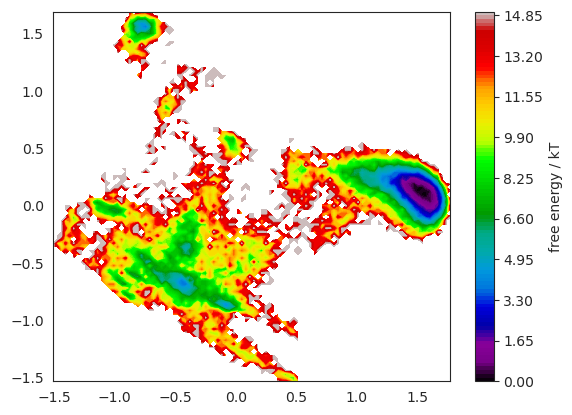

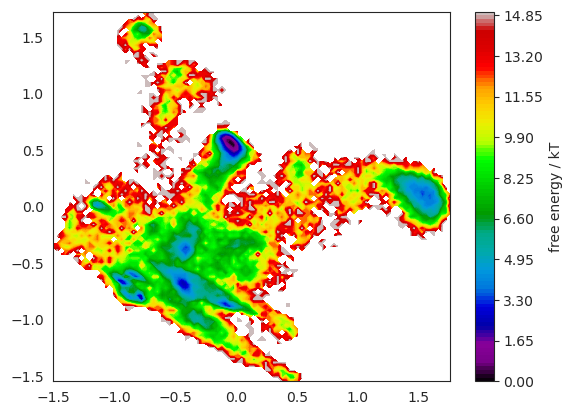

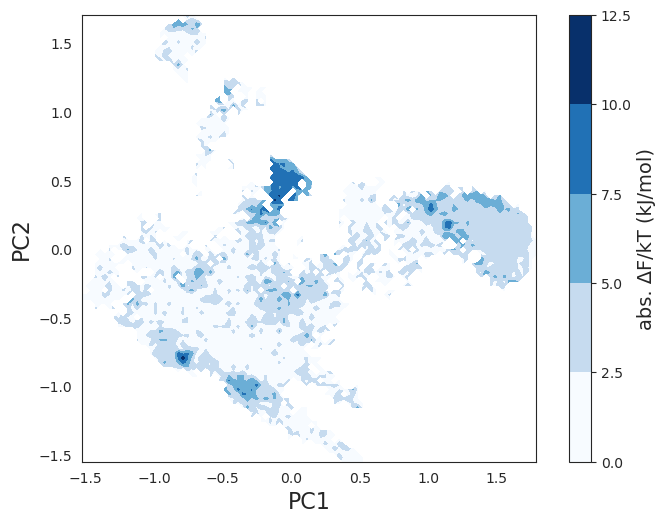

In [25]:
import pyemma


#Calculate the F.E. energy surfaces for each run (f1 and f2) and get their absolute difference.

dims = [0, 1]

x1 = X[0*fr_per_trj:1*fr_per_trj, dims[0]]
y1 = X[0*fr_per_trj:1*fr_per_trj, dims[1]]
fig, ax, f1 = pyemma.plots.plot_free_energy(x1, y1, kT=2.48)

x2 = X[1*fr_per_trj:2*fr_per_trj, dims[0]]
y2 = X[1*fr_per_trj:2*fr_per_trj, dims[1]]
fig, ax, f2 = pyemma.plots.plot_free_energy(x2, y2, kT=2.48)

f1 = np.asarray(f1)
f2 = np.asarray(f2)

f_err = np.absolute(f1-f2)

#Plot the F.E. difference. Contours are multiples of kT as 300K.
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8.3,5.8))
ax.set_aspect(1)

x = X[0*fr_per_trj:1*fr_per_trj, dims[0]]
y = X[0*fr_per_trj:1*fr_per_trj, dims[1]]

x, y, z, xmin, xmax, ymin, ymax = density_estimation(x, y)

bounds = [0, 2.5, 5.0, 7.5, 10.0, 12.5]
cmap=plt.cm.get_cmap("Blues", 5)
norm=mpl.colors.BoundaryNorm(bounds, cmap.N)
# norm = cm.colors.Normalize(vmax=abs(f_err).max(), vmin=-abs(f_err).max())

# CS = ax.contourf(x, y, f_err.T, 14, cmap="Reds") #we want to use ff-specific color codes.
CS = ax.contourf(x, y, f_err.T, bounds, cmap=cmap, norm=norm) #we want to use ff-specific color codes.

ax.set_xlabel("PC%d"%(dims[0]+1), fontsize=16)
ax.set_ylabel("PC%d"%(dims[1]+1), fontsize=16)

cbar = fig.colorbar(CS, ax=ax, ticks=bounds)
cbar.set_label('abs. ΔF/kT (kJ/mol)', fontsize=14, rotation=90, x=1.05)

plt.savefig("%s/Gvec_DeltaF-alltraj_pc_1-2.png" %(outdir), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.plot()

/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  


[]

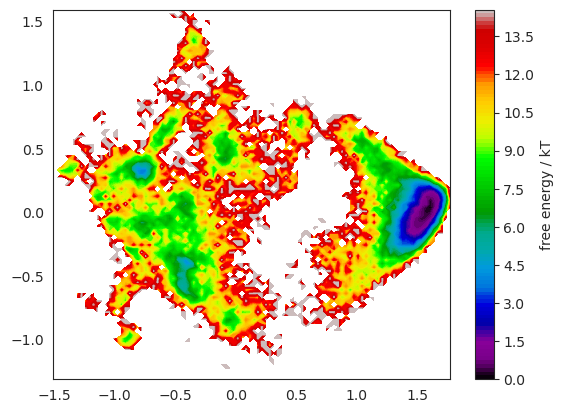

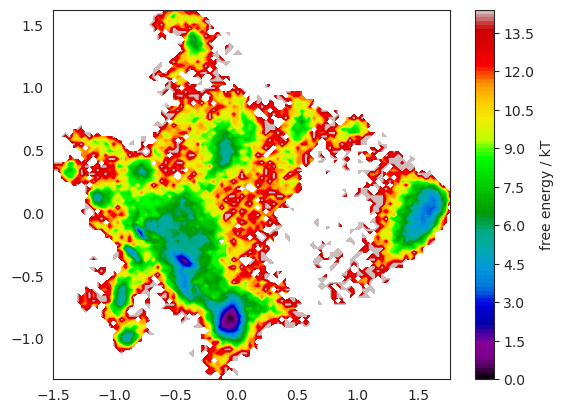

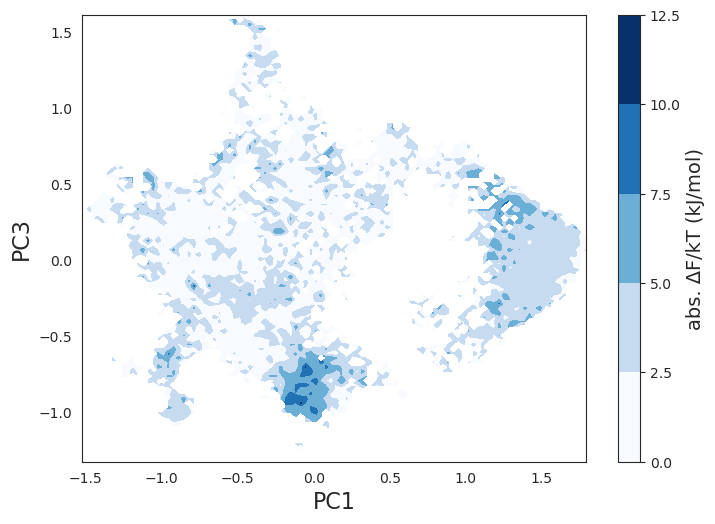

In [26]:
dims = [0, 2]

x1 = X[0*fr_per_trj:1*fr_per_trj, dims[0]]
y1 = X[0*fr_per_trj:1*fr_per_trj, dims[1]]
fig, ax, f1 = pyemma.plots.plot_free_energy(x1, y1, kT=2.48)

x2 = X[1*fr_per_trj:2*fr_per_trj, dims[0]]
y2 = X[1*fr_per_trj:2*fr_per_trj, dims[1]]
fig, ax, f2 = pyemma.plots.plot_free_energy(x2, y2, kT=2.48)

f1 = np.asarray(f1)
f2 = np.asarray(f2)

f_err = np.absolute(f1-f2)

#Plot the F.E. difference. Contours are multiples of kT as 300K.
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8.3,5.8))
ax.set_aspect(1)

x = X[0*fr_per_trj:1*fr_per_trj, dims[0]]
y = X[0*fr_per_trj:1*fr_per_trj, dims[1]]

x, y, z, xmin, xmax, ymin, ymax = density_estimation(x, y)

bounds = [0, 2.5, 5.0, 7.5, 10.0, 12.5]
cmap=plt.cm.get_cmap("Blues", 5)
norm=mpl.colors.BoundaryNorm(bounds, cmap.N)
# norm = cm.colors.Normalize(vmax=abs(f_err).max(), vmin=-abs(f_err).max())

# CS = ax.contourf(x, y, f_err.T, 14, cmap="Reds") #we want to use ff-specific color codes.
CS = ax.contourf(x, y, f_err.T, bounds, cmap=cmap, norm=norm) #we want to use ff-specific color codes.

ax.set_xlabel("PC%d"%(dims[0]+1), fontsize=16)
ax.set_ylabel("PC%d"%(dims[1]+1), fontsize=16)

cbar = fig.colorbar(CS, ax=ax, ticks=bounds)
cbar.set_label('abs. ΔF/kT (kJ/mol)', fontsize=14, rotation=90, x=1.05)

plt.savefig("%s/Gvec_DeltaF-alltraj_pc_1-3.png" %(outdir), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.plot()

# Single run results 

<span style="font-size:15pt;">Same process for individual nmr-seeded and simrna-seeded trajectories (traj1 or traj2) reproduces published data (code not included)</span>

In [27]:
# Include the native and seed states in trj snippet G-vecs. ("z_" prefix puts it at the end of the list)
native = md.load("%s/reference_structures/UUCG-native.pdb"%indir)
native.save("%s/z_UUCG-native.pdb"%outdir)
bb.snippet("%s/z_UUCG-native.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

seed1 = md.load("%s/reference_structures/UUCG-nmr.pdb"%indir)
seed1.save("%s/z_UUCG-nmr.pdb"%outdir)
bb.snippet("%s/z_UUCG-nmr.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

seed2 = md.load("%s/reference_structures/UUCG-simrna.pdb"%indir)
seed2.save("%s/z_UUCG-simrna.pdb"%outdir)
bb.snippet("%s/z_UUCG-simrna.pdb"%outdir, sequence=sequence, outdir="%s/snippets"% outdir)

NUM_REFS=3  #number of reference structures

# list the files and print the sequence. Could take a lot of time, and can be skipped.
flist = glob.glob("%s/snippets/*.pdb"%outdir)

print("Total number of fragments with sequence %10s: %6d\n\n" %(sequence, len(flist)))

# Initializing file ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-native.pdb


# Writing PDB z_UUCG-native_6_U_A_0_00000.pdb


# Initializing file ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-nmr.pdb
# Initializing file ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-simrna.pdb


# Writing PDB z_UUCG-nmr_6_U_A_0_00000.pdb
# Writing PDB z_UUCG-simrna_6_U_A_0_00000.pdb


Total number of fragments with sequence       UUCG: 100005




In [28]:
# Cluster the structure obtained from the previous steps.

#calculate eRMSD from native.
ermsd = bb.ermsd(reference, traj1, topology=topol) #using traj1 as an example
ermsd_native = bb.ermsd(reference, "%s/z_UUCG-native.pdb"%outdir, topology=topol)
ermsd_seed1 = bb.ermsd(reference, "%s/z_UUCG-nmr.pdb"%outdir, topology=topol)
ermsd_seed2 = bb.ermsd(reference, "%s/z_UUCG-simrna.pdb"%outdir, topology=topol)
print(ermsd, ermsd_native, ermsd_seed1, ermsd_seed2)

#calculate RMSD from native using backbone heavy atoms of all nucleotides.
rmsd = bb.rmsd(reference, traj1, topology=topol, heavy_atom=False)

#calculate the G-vectors
#flist = glob.glob("%s/snippets/*.pdb"%outdir)
if(len(flist)==0):
    print("# You need to create a .pdb trajectory using e.g. gmx trjconv...")
    exit()
else:    
    print("Total number of fragments with sequence %s:"%sequence, len(flist))

    
# calculate G-vectors for all files (based on position vectors R).
# Gαβ vector cutoff is 2.4 Ang.
up_thresh=2.0 #only structures with eRMSD <= up_thresh will be considered. 
qq = np.where(ermsd<up_thresh)[0]
print("eRMSD < %1.2f array shape: "%up_thresh, qq.shape)
print("len. of eRMSDs < %1.2f "%up_thresh, len(ermsd[qq]))


try:
    gvecs = np.loadtxt("%s/snippets/Gvecs.txt"%outdir)
    print("G-vec file exists!")
    if len(gvecs)==len(ermsd[qq])+NUM_REFS:   #ACCOUNT FOR THE ADDITION OF NATIVE STATE AND SEED STATES
        print("G-vecs loaded!")
        print(gvecs.shape)
        n = gvecs.shape[0]
        print("G-vecs length: ", n)

    else:
        print("Native/seed states not in G-vec set. G-vecs need recalculation!")
except:
    print("We\'re in trouble..")

# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ..//REST2_dynamics/UUCG/300K/trajectories/traj-ff14SB-nmr.xtc 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-native.pdb 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-nmr.pdb 
# Loaded reference ..//REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/z_UUCG-simrna.pdb 


[0.42329955 0.52868025 0.46431981 ... 1.07392496 1.14370348 1.21719649] [0.] [0.28403547] [0.96303801]
# found  165 atoms in common
Total number of fragments with sequence UUCG: 100005
eRMSD < 2.00 array shape:  (50001,)
len. of eRMSDs < 2.00  50001
G-vec file exists!
Native/seed states not in G-vec set. G-vecs need recalculation!


In [29]:
# (cut eRMSDs etc in half and work on that)
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist


alltraj_dir="%s/../Gvec_clusters"%outdir #directory with Gvecs of combined FF trj
nmr = "%s/reference_structures/2KOC.pdb"%indir #experimental NMR models

traj = "%s/../traj-ff14SB-nmr.xtc" % outdir  #needs to have the same number of atoms as the reference pdb.
# traj = "%s/../traj-ff14SB-simrna.xtc" % outdir  #needs to have the same number of atoms as the reference pdb.
alltraj = "%s/../traj_all_ffs-rna-center.xtc" % alltraj_dir  #needs to have the same number of atoms as the reference pdb.

sequence = "UUCG"
# gvecs_temp=np.loadtxt("%s/snippets/Gvecs.txt"%outdir)
gvecs = np.loadtxt("/mnt/c/Users/dista/OneDrive - University of Southampton/Reports-vivas-presentations/Papers/Paper_1-RNA_benchmark/with_revised_data/data/Analysis/UUCG/Gvec_conformations/300K/ff14SB/nmr_run/Gvecs.txt") #precalculated on traj1

alltraj_gvecs="%s/snippets/Gvecs.txt"%alltraj_dir
alltraj_gvecs=np.loadtxt(alltraj_gvecs)
#uncomment as needed
# gvecs = np.concatenate((gvecs[:len(gvecs_temp[:-NUM_REFS])//2], gvecs_temp[-NUM_REFS:])) #consider only traj1
gvecs = np.concatenate((gvecs[:len(ermsd[qq])], alltraj_gvecs[-NUM_REFS:])) #consider only traj1
# gvecs = gvecs[len(gvecs[:-NUM_REFS])//2:] #consider only traj2

print(gvecs.shape)
print(alltraj_gvecs.shape)

(50004, 64)
(80011, 64)


In [30]:
# Calculate G-vecs of NMR ensemble models.

# bb.snippet(nmr, sequence=sequence, outdir="%s/snippets_pdb"% outdir)
flist_nmr = glob.glob("%s/snippets_pdb/*.pdb"%alltraj_dir)

gvecs_nmr = []
for f in flist_nmr:
    gvec_nmr, seq_nmr = bb.dump_gvec(f)
    gvecs_nmr.extend(gvec_nmr)
    
gvecs_nmr = np.array(gvecs_nmr)
n_nmr = gvecs_nmr.shape[0]
# gvecs_nmr = gvecs_nmr.reshape(n_pdb,-1)[np.where(ermsd_pdb<up_thresh)]
gvecs_nmr = gvecs_nmr.reshape(n_nmr,-1) #NOT IMPOSING ANY THRESHOLD

print(gvecs_nmr.shape)

# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00000.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00001.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00002.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00003.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00004.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00005.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00006.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00007.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00008.pdb 
# Loading ../output/UUCG/300

(20, 64)


# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00015.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00016.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00017.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00018.pdb 
# Loading ../output/UUCG/300K/Gvec_clusters-single_FF/../Gvec_clusters/snippets_pdb/2KOC_6_U_A_0_00019.pdb 


In [31]:
#Do PCA with 3 features (to be comparable with previous PCA/DBSCAN decomposition of G-vecs).
#Will embed the Gvecs of this ff to a space common to all ffs.
dims=3
pca = PCA(n_components=dims)
pca.fit(alltraj_gvecs) #creating a PC space from all trajectories.
X = pca.transform(gvecs) #these are the ff-specific data transformed in alltraj PC space.
NMR = pca.transform(gvecs_nmr)

print(pca.explained_variance_)
print(["%2.2f"%(i*100)+"%" for i in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.73713782 0.56135227 0.33260168]
['21.18%', '16.13%', '9.56%']
0.46865934339326765


In [32]:
#try DBSCAN with usual eps value.
eps=0.5
min_samples=200

gvecs_dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=2)
gvecs_dbscan.fit(gvecs)

labels = gvecs_dbscan.labels_# label=-1 means the point is an outlier. Rest of the values represent the label/cluster number starting from 0
print(labels)

# Creating a numpy array with all values set to false by default
core_samples_mask = np.zeros_like(labels, dtype=bool)
# Setting core and border points (all points that are not -1) to True
core_samples_mask[gvecs_dbscan.core_sample_indices_] = True

# Finding the number of clusters in labels (ignoring noise if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d"%n_noise_, "(%.1f%s)"%(100*n_noise_/gvecs.shape[0],"%"))

# Evaluating the quality of clusters
s = metrics.silhouette_score(gvecs, gvecs_dbscan.labels_)
print(f"Silhouette Coefficient for the Dataset Clusters: {s:.2f}")

[ 0 -1  0 ...  0  0 -1]
Estimated number of clusters: 9
Estimated number of noise points: 16964 (33.9%)
Silhouette Coefficient for the Dataset Clusters: 0.23


In [33]:
#find cluster centroids (i.e. members with lowest sum of intra-cluster eRMSDs).
unique_labels = set(labels)

cent_idxs = dbscan_centers(gvecs, labels, unique_labels)
print(cent_idxs)

#find cluster populations relative to total data.
print("Noise population: %.1f"%(100*np.sum(labels==(-1))/labels.shape[0])+"%")
pops = [(np.sum(labels==i)/labels.shape[0] *100) for i in range(len(unique_labels)-1)]
print(pops)

sorted_pops = np.sort(pops)[::-1] #create a reverse-sorted copy

#create a dictionary that relates sorted cluster indexes (keys: 0 is largest cluster) to DBSCAN cluster labels (values).
sort_clust_map={}
i=0
while i < len(cent_idxs):
    #This accounts for multiple clusters with same populations.
    if len(np.where(pops==sorted_pops[i])[0]) > 1:
        dupl_count=len(np.where(pops==sorted_pops[i])[0])
        for j in range(dupl_count):
            sort_clust_map[i+j]=int(np.where(pops==sorted_pops[i])[0][j])
        i+=(dupl_count)
    #This accounts for clusters with unique populations.
    else:        
        sort_clust_map[i]=int(np.where(pops==sorted_pops[i])[0][0])
        i+=1
print(sort_clust_map)

Finding centroid for cluster...0
Finding centroid for cluster...1
Finding centroid for cluster...2
Finding centroid for cluster...3
Finding centroid for cluster...4
Finding centroid for cluster...5
Finding centroid for cluster...6
Finding centroid for cluster...7
Finding centroid for cluster...8
[6610, 33285, 2305, 10099, 9275, 14166, 34533, 40372, 44074]
Noise population: 33.9%
[2.2938164946804256, 1.6438684905207586, 57.89136869050476, 0.8959283257339412, 1.2199024078073752, 0.6059515238780897, 0.4119670426365891, 0.3999680025597952, 0.7119430445564355]
{0: 2, 1: 0, 2: 1, 3: 4, 4: 3, 5: 8, 6: 5, 7: 6, 8: 7}


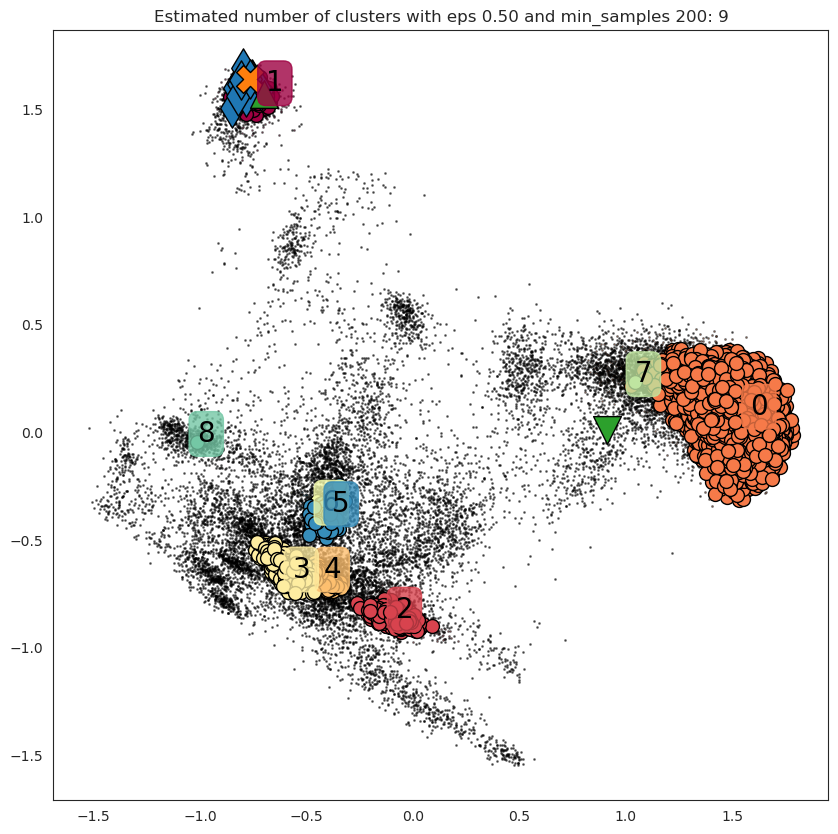

In [34]:
#Plot the results.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10,10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = "k"
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]  #Plot the points on the PC space.
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col, markeredgecolor="k", markersize=10)    

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col, markeredgecolor="k", markersize=1, zorder=1, alpha=0.5)

#Plot native/seed states. We know their indexes from notebook #4
plt.scatter(X[-3,0], X[-3,1], s=400, lw=1, c="tab:orange", ec='black', zorder=2*len(unique_labels)+1, marker="X")
plt.scatter(X[-2,0], X[-2,1], s=400, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="^")
plt.scatter(X[-1,0], X[-1,1], s=400, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="v")
plt.scatter(NMR[:,0], NMR[:,1], s=400, lw=1, c="tab:blue", ec="black", zorder=2*len(unique_labels), marker="d")

#Add centroid labels.
for i in range(len(unique_labels)-1):
    plt.annotate(list(sort_clust_map.keys())[list(sort_clust_map.values()).index(i)], (X[cent_idxs[i],0], X[cent_idxs[i],1]), c='k', zorder=3*len(unique_labels), \
                 fontsize=20, bbox=dict(boxstyle="round", alpha=0.8, color=colors[i]))

plt.title("Estimated number of clusters with eps %.2f and min_samples %d: %d" %(eps, min_samples, n_clusters_))
plt.show()

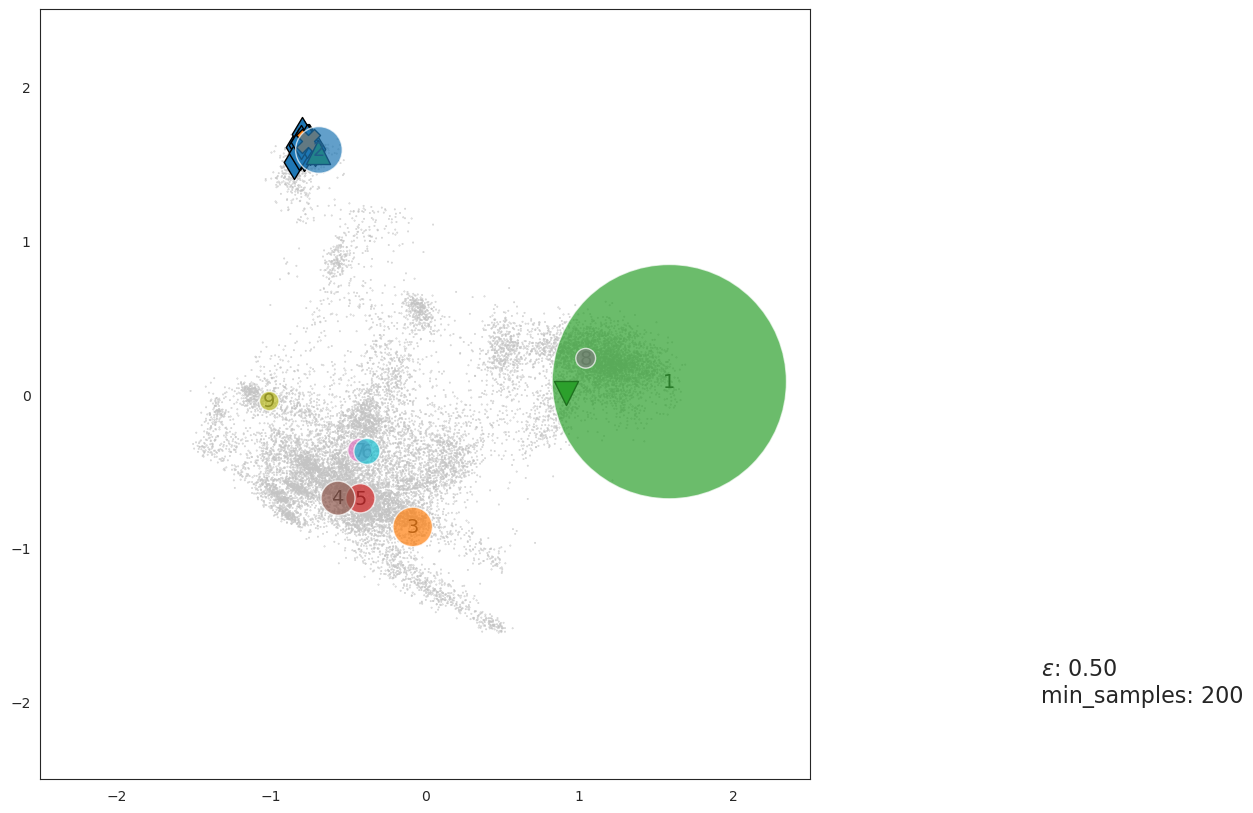

In [35]:
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

#define figure and set aspect.
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

# #calculate explained variance for the first two components.
# plt.xlabel(r'PC1 (%2.0f%s)' %(v[0]*100,"%"), fontsize=12)
# plt.ylabel(r'PC2 (%2.0f%s)' %((v[1]-v[0])*100,"%"), fontsize=12)
# print("# Cumulative explained variance percentage: PC1=%5.1f PC2=%5.1f PC3=%5.1f" %(v[0]*100,v[1]*100,v[2]*100))

#define colors for clusters. Noise is grey points.
cp = sns.color_palette("hls", n_colors=len(cent_idxs), desat=0.8)
colors = [cp[j-1] if (j!=-1) else (0.77,0.77,0.77) for j in labels]
size = [0.12 if (j==-1) else 0.0 for j in labels]

#scatterplot all points.
plt.scatter(X[:,0],X[:,1], s=size, c=colors, zorder=0)
plt.scatter(X[-3,0], X[-3,1], s=300, lw=1, c="tab:orange", ec="black", zorder=2*len(unique_labels)+1, marker="X")
plt.scatter(X[-2,0], X[-2,1], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="^")
plt.scatter(X[-1,0], X[-1,1], s=300, lw=1, c="tab:green", ec="black", zorder=2*len(unique_labels)+2, marker="v")
plt.scatter(NMR[:,0], NMR[:,1], s=300, lw=1, c="tab:blue", ec="black", zorder=2*len(unique_labels), marker="d")

#make circles in the center of the cluster
patches = []
new_labels = np.array(labels)
for i,k in enumerate(cent_idxs):
    plt.text(X[cent_idxs[i],0], X[cent_idxs[i],1], \
             list(sort_clust_map.keys())[list(sort_clust_map.values()).index(i)]+1, \
             ha="center", va="center", fontsize=14, zorder=3*len(unique_labels))
    #make the circle radius proportional to the square root of the cluster size.
    rr = np.sqrt(1.*len(np.where(new_labels==i)[0])/len(new_labels))
    circle = mpatches.Circle((X[k,0], X[k,1]), rr, ec='black', lw=4)
    patches.append(circle)
p = PatchCollection(patches, cmap=mpl.cm.tab10, alpha=0.7, zorder=3*len(unique_labels))
p.set_array(np.arange(len(cent_idxs))+1)
ax.add_collection(p)

#set nice limits
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-2,-1,0,1,2])
props = dict(boxstyle='round', facecolor='white', alpha=0.3)
plt.text(4, -2, s=r'$\epsilon$: %.2f'%eps+"\n"+"min_samples: %d"%min_samples, bbox=props, fontsize=16)
# plt.title("G-vector PCA - eRMSD threshold %s" %up_thresh, fontsize=16)
plt.savefig("%s/Gvec_clusters-w_radius-PC1_PC2-eps%s_min%s-single_run.png" %(outdir, eps, min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

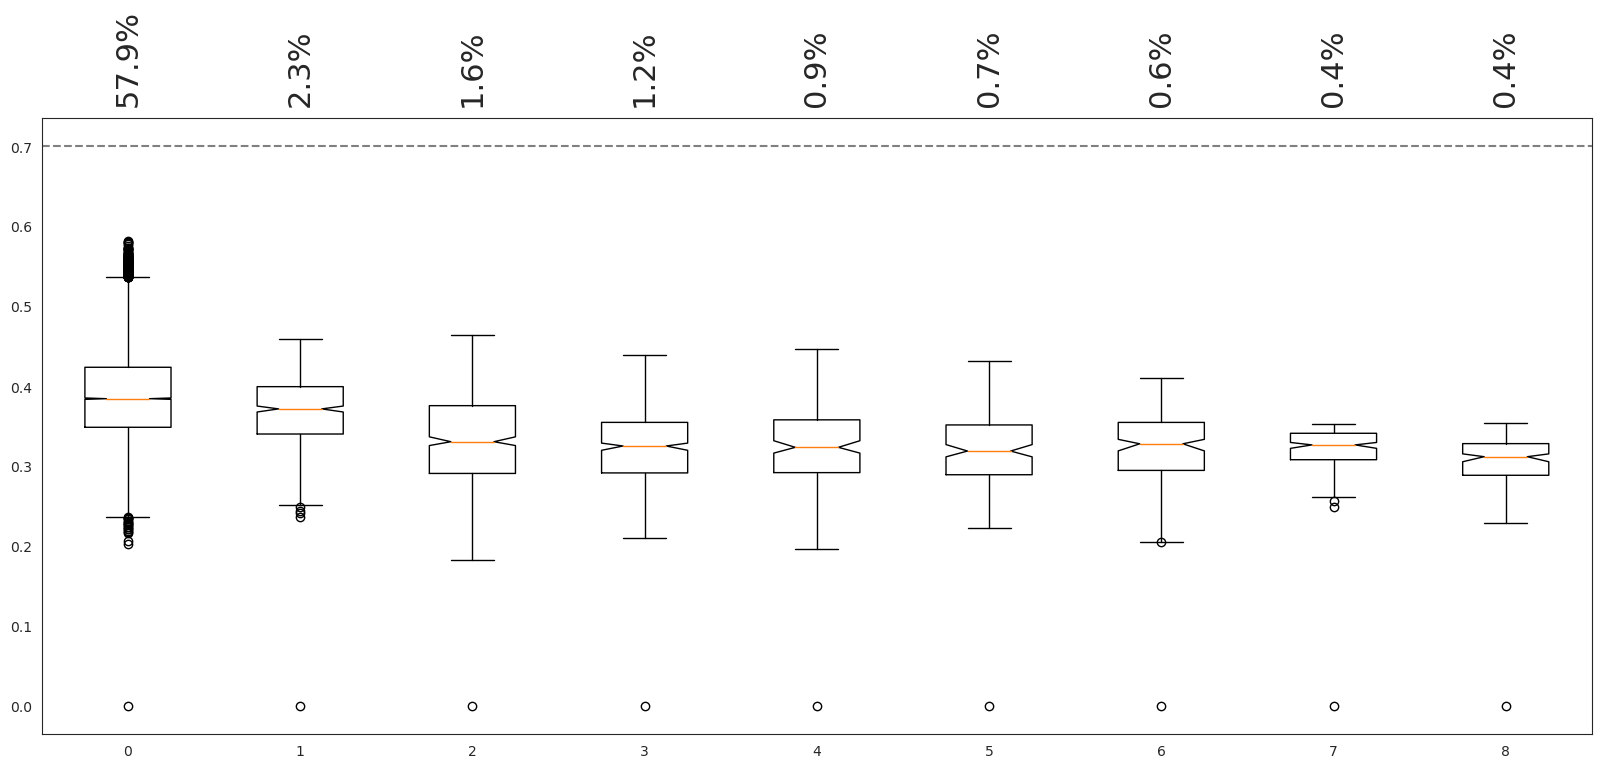

In [36]:
#calculate intra-cluster loop eRMSDs.
ermsds = ermsd_cluster(gvecs, gvecs[cent_idxs], labels)

ermsds_sorted = [ermsds[i] for i in list(sort_clust_map.values())]

#plot intra-cluster eRMSDs along with cluster populations. 
#Distributions might differ from Barnaba because it calculates intra-cluster eRMSDs using whole structures!
plt.figure(figsize=(20, 8))
plt.boxplot(ermsds_sorted, notch=True, bootstrap=1000, labels=range(len(cent_idxs)))
for j in range(len(sorted_pops)):
    plt.text((j+1), 0.75, "%.1f%s"%(sorted_pops[j],"%"), ha='center', va='bottom', rotation=90, fontsize=22)
plt.axhline(0.7, ls='--', c='grey')

plt.show()

In [37]:
# Save the cluster centroids to PDB files and cluster members to xtc trajectories for further analysis.

clustdir = "%s/snippet_clusters-eps%s_min%s-single_run" %(outdir, eps, min_samples)
os.system("mkdir %s" % clustdir)

print("# Write centroids to PDB files and cluster members to .xtc")
t=md.load(traj1, top=topol)
print(t)

# Write centroids to PDB files and cluster members to .xtc
<mdtraj.Trajectory with 50001 frames, 447 atoms, 14 residues, and unitcells>


In [38]:
dd1 = []  #will store the eRMSDs of each frame to its centroid.
dd2 = []  #will store the RMSDs of each frame to its centroid.
ll = []  #will store the cluster population relative to all the frames. 

for i,k in enumerate([cent_idxs[j] for j in sort_clust_map.values()]):
    print(qq[k])
    t[qq[k]].save_gro("%s/cluster_%03d.gro" %(clustdir, i))
#     idxs = [ii for ii,kk in enumerate(new_labels[:-NUM_REFS]) if(kk==i+1)] #exclude native/seed states
    idxs = [ii for ii,kk in enumerate(new_labels[:-NUM_REFS]) if(kk==sort_clust_map[i])] #exclude native/seed states
#     idxs = np.where(new_labels[:-NUM_REFS]==sort_clust_map[i])[0] #exclude native/seed states 
    print(len(idxs))
    t[qq[idxs]].save_xtc("%s/cluster_%03d.traj.xtc" %(clustdir, i))
    ll.append(100.*len(idxs)/len(t))
    ermsd_t = bb.ermsd("%s/cluster_%03d.gro" %(clustdir,i), "%s/cluster_%03d.traj.xtc" %(clustdir, i), topology=topol)
    rmsd_t = bb.rmsd("%s/cluster_%03d.gro" %(clustdir,i), "%s/cluster_%03d.traj.xtc" %(clustdir,i), topology=topol, heavy_atom=False)
    dd1.append(ermsd_t)
    dd2.append(rmsd_t)

2305
28948


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_000.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_000.traj.xtc 


# found  165 atoms in common
6610
1145


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_001.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_001.traj.xtc 


# found  165 atoms in common
33285
822


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_002.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_002.traj.xtc 


# found  165 atoms in common
9275
610


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_003.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_003.traj.xtc 


# found  165 atoms in common
10099
448


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_004.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_004.traj.xtc 


# found  165 atoms in common
44074
356


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_005.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_005.traj.xtc 


# found  165 atoms in common
14166
303


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_006.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_006.traj.xtc 


# found  165 atoms in common
34533
206


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_007.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_007.traj.xtc 


# found  165 atoms in common
40372
200


# Loaded reference ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_008.gro 
# Loaded target ../output/UUCG/300K/Gvec_clusters-single_FF/snippet_clusters-eps0.5_min200-single_run/cluster_008.traj.xtc 


# found  165 atoms in common


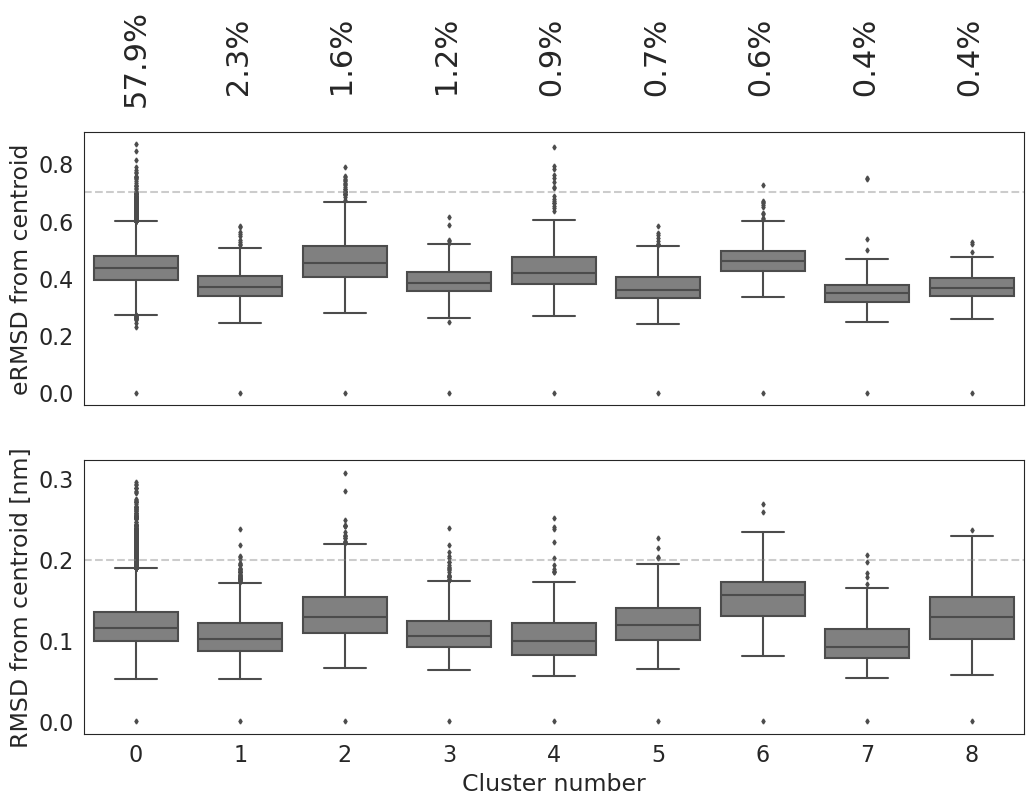

In [39]:
# Box-plot the clustered data to get population statistics (e.g. we can see cluster compactness).

#define the figure.
f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(11,7))
#do the boxplot
ax1 = sns.boxplot(data=dd1, color='0.5', ax=ax1, fliersize=2.5)
ax1.axhline(0.7, color='grey', alpha=0.4, ls='--')

ax2 = sns.boxplot(data=dd2, color='0.5', fliersize=2.5)
ax2.axhline(0.2, color='grey', alpha=0.4, ls='--')

#write percentages.
for j in range(len(ll)):
    ax1.text(j, 1.0, "%4.1f%s" %(ll[j],"%"), ha='center', va='bottom', rotation=90, fontsize=22)
#set limits and labels
ax1.set_ylabel("eRMSD from centroid", fontsize=17)
ax1.tick_params(axis='both', labelsize=16)

# ax2.set_ylim(0, 0.5)
ax2.set_ylabel("RMSD from centroid [nm]", fontsize=17)
ax2.set_xlabel("Cluster number", fontsize=17)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticklabels([str(i) for i in range(len(ll))])
plt.subplots_adjust(right=0.98, top=0.97)
plt.savefig("%s/eRMSD_cluster_boxplts-eps%s_min%s-single_run.png" %(outdir, eps*np.sqrt(len(sequence)), min_samples), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()